# Test Symmetry and Monotonicity Operators

These will eventually become tests in meas_deblender, but for now we use them just to ensure that our operators are working properly

In [1]:
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import proximal, proximal_nmf
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

# Numerically show that the symmetry operator is working as expected

This cell tests the symmetry operator on rectangular (non-square) matrices with the peak in different quadrants, verifying that the symmetry operator is working correctly on all of them

In [2]:
# This is just a visual sanity check
# The cells that follow are a more numerical check
def testSym(xslice, yslice, px, py, shape=(4,5), fillValue=0):
    x = np.ones(shape)
    x[yslice,xslice] = [[1,2,3],[5,6,7],[9,10,11]]
    symmetryOp = proximal_nmf.getPeakSymmetry(shape, px, py, fillValue)
    print('template\n', x)
    result = symmetryOp.dot(x.flatten()).reshape(x.shape)
    print('symmetric template\n', result)
    return result

result = testSym(slice(None,3),slice(None,3),1,1)
testSym(slice(-3,None),slice(-3, None),3,2, fillValue=-1)
testSym(slice(None,3),slice(-3,None),1,2, fillValue=-2)
testSym(slice(-3,None),slice(None,3),3,1)
testSym(slice(None,3),slice(None,3),2,2, shape=(5,5))

template
 [[  1.   2.   3.   1.   1.]
 [  5.   6.   7.   1.   1.]
 [  9.  10.  11.   1.   1.]
 [  1.   1.   1.   1.   1.]]
symmetric template
 [[ 11.  10.   9.   0.   0.]
 [  7.   6.   5.   0.   0.]
 [  3.   2.   1.   0.   0.]
 [  0.   0.   0.   0.   0.]]
template
 [[  1.   1.   1.   1.   1.]
 [  1.   1.   1.   2.   3.]
 [  1.   1.   5.   6.   7.]
 [  1.   1.   9.  10.  11.]]
symmetric template
 [[ -1.  -1.  -1.  -1.  -1.]
 [ -1.  -1.  11.  10.   9.]
 [ -1.  -1.   7.   6.   5.]
 [ -1.  -1.   3.   2.   1.]]
template
 [[  1.   1.   1.   1.   1.]
 [  1.   2.   3.   1.   1.]
 [  5.   6.   7.   1.   1.]
 [  9.  10.  11.   1.   1.]]
symmetric template
 [[ -2.  -2.  -2.  -2.  -2.]
 [ 11.  10.   9.  -2.  -2.]
 [  7.   6.   5.  -2.  -2.]
 [  3.   2.   1.  -2.  -2.]]
template
 [[  1.   1.   1.   2.   3.]
 [  1.   1.   5.   6.   7.]
 [  1.   1.   9.  10.  11.]
 [  1.   1.   1.   1.   1.]]
symmetric template
 [[  0.   0.  11.  10.   9.]
 [  0.   0.   7.   6.   5.]
 [  0.   0.   3.   2.   1.]
 [  0

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,  11.,  10.,   9.],
       [  1.,   1.,   7.,   6.,   5.],
       [  1.,   1.,   3.,   2.,   1.]])

# Test the symmetry operator on a 2D Gaussian matrix

Place the peak in each quadrant and ensure that the symmetry difference operator, the difference between the original and symmetric image, is ~zero.

In [3]:
def gaussian2D(x, y, x0=0, y0=0, A=1, sigma=0.25):
    return A*np.exp(-0.5*((x-x0)**2+(y-y0)**2)/sigma)

def testSym(symmetricPatch, xslice, yslice, px, py, shape, zeros=True, fillValue=0):
    # Offset the symmetric patch depending on the shape of the image and position of the peak
    width = symmetricPatch.shape[0]
    if zeros:
        img = np.zeros(shape)
    else:
        img = 0.5*np.ones(shape)
    img[yslice, xslice] = symmetricPatch
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')
    plt.show()
    # Create a symmetry operator for the image
    symOp = proximal_nmf.getPeakSymmetry(img.shape, px, py, fillValue)
    imgSym = symOp.dot(img.flatten()).reshape(img.shape)
    plt.imshow(imgSym)
    plt.title("Symmetric")
    plt.axis('off')
    plt.show()
    # Create the symmetry difference operator: (1-symmetryOp)
    diffOp = proximal_nmf.getPeakSymmetryOp(img.shape, px, py, fillValue)
    diff = diffOp.dot(img.flatten())
    logger.info("Max difference: {0}".format(np.max(diff)))
    logger.info("Min difference: {0}".format(np.min(diff)))
    return np.max(diff), img, imgSym, diff

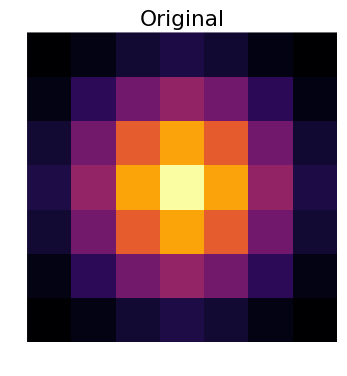

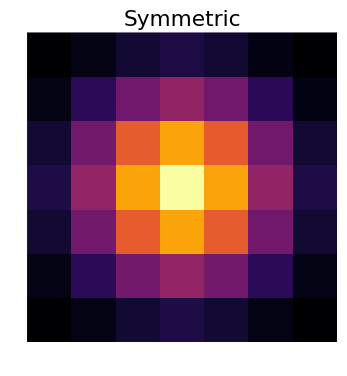

INFO:lsst.meas.deblender:Max difference: 2.77555756156e-16
INFO:lsst.meas.deblender:Min difference: -2.77555756156e-16


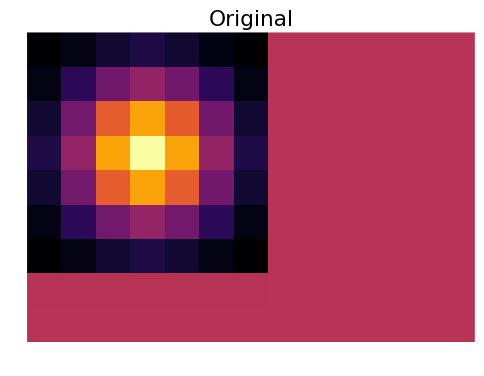

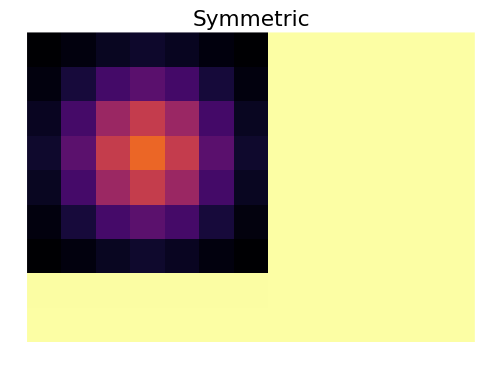

INFO:lsst.meas.deblender:Max difference: 2.77555756156e-16
INFO:lsst.meas.deblender:Min difference: -1.0


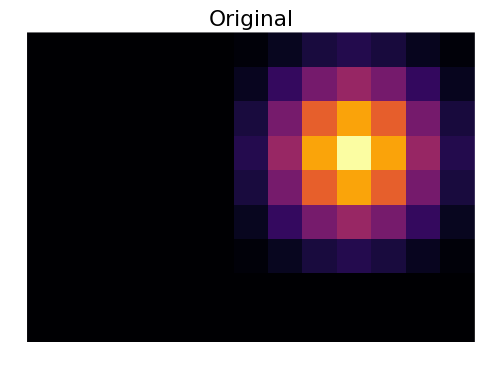

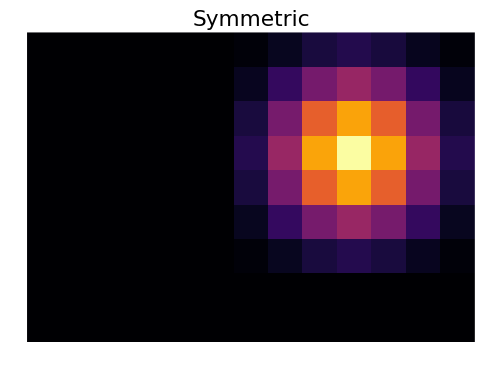

INFO:lsst.meas.deblender:Max difference: 2.77555756156e-16
INFO:lsst.meas.deblender:Min difference: -2.77555756156e-16


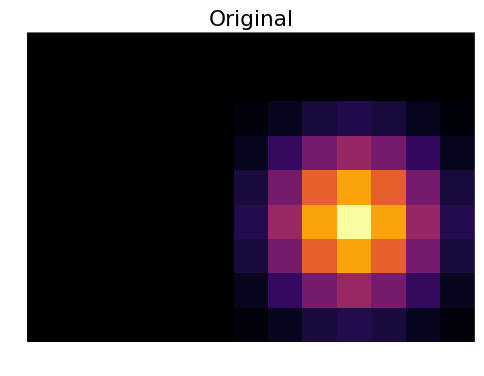

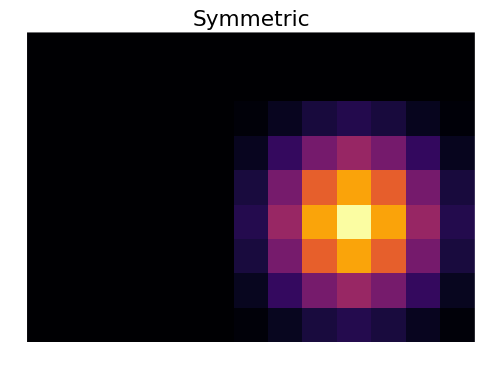

INFO:lsst.meas.deblender:Max difference: 2.77555756156e-16
INFO:lsst.meas.deblender:Min difference: -2.77555756156e-16


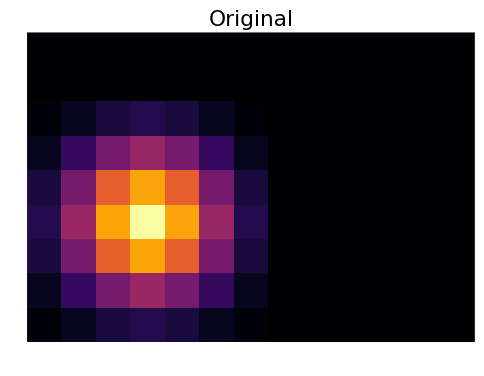

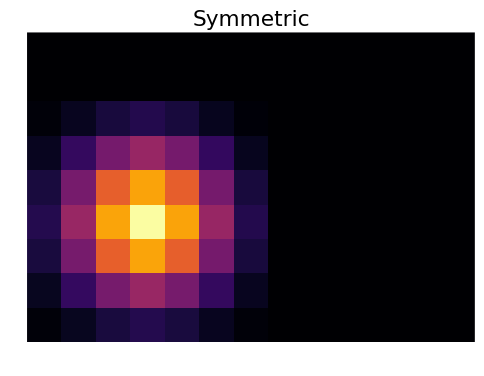

INFO:lsst.meas.deblender:Max difference: 2.77555756156e-16
INFO:lsst.meas.deblender:Min difference: -2.77555756156e-16


In [4]:
# Create the Gaussian to use for the test
x = np.linspace(-1,1,7)
y = np.linspace(-1,1,7)
X,Y = np.meshgrid(x,y)
patch = gaussian2D(X, Y)
width = x.shape[0]
center = int(0.5*(width-1))
shape = (width+2, width+6)
cx, cy = (center, center)

testSym(patch, slice(None, None), slice(None, None), cx, cy, (width, width));
testSym(patch, slice(None, width), slice(None, width), cx, cy, shape, fillValue=3, zeros=False);
testSym(patch, slice(-width, None), slice(None, width), shape[1]-cx-1, cy, shape);
testSym(patch, slice(-width, None), slice(-width, None), shape[1]-cx-1, shape[0]-cy-1, shape);
testSym(patch, slice(None, width), slice(-width, None), cx, shape[0]-cy-1, shape);

# Test non-symmetric

Next run the same test with a non-zero background, which will cause the original and symmetric images to have a difference of 0.5

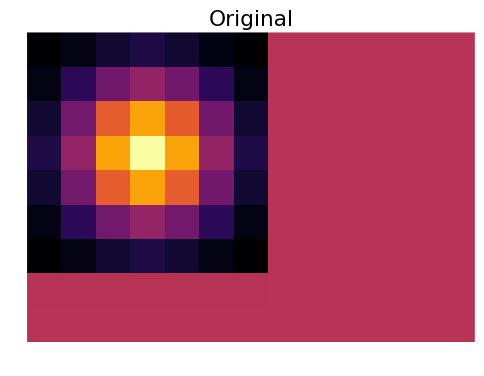

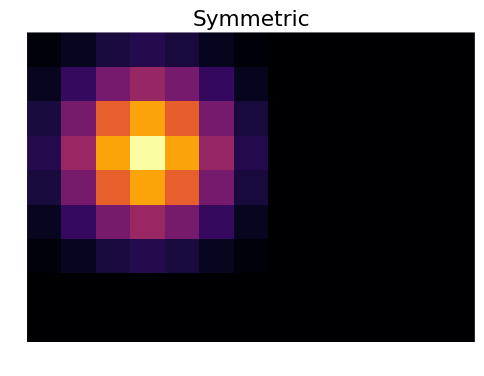

INFO:lsst.meas.deblender:Max difference: 0.5
INFO:lsst.meas.deblender:Min difference: -2.77555756156e-16


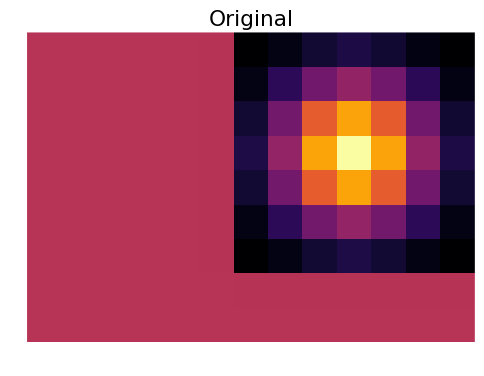

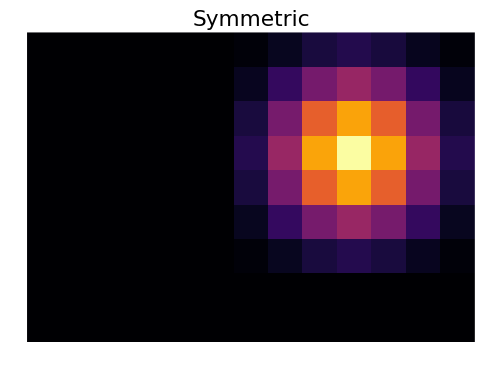

INFO:lsst.meas.deblender:Max difference: 0.5
INFO:lsst.meas.deblender:Min difference: -2.77555756156e-16


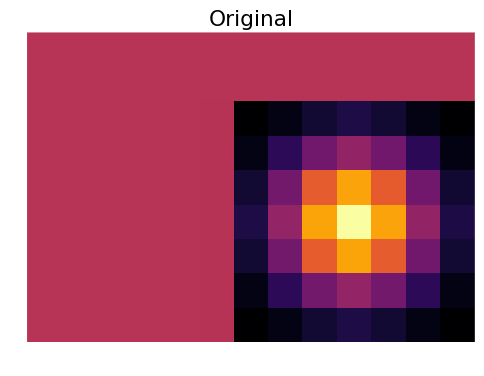

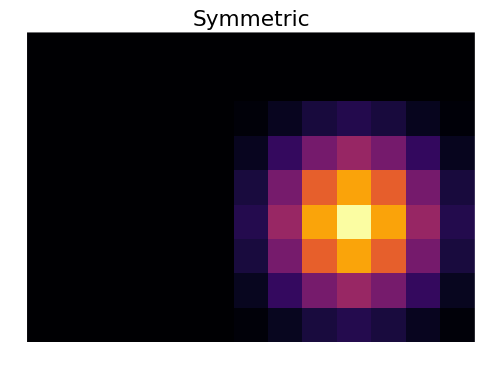

INFO:lsst.meas.deblender:Max difference: 0.5
INFO:lsst.meas.deblender:Min difference: -2.77555756156e-16


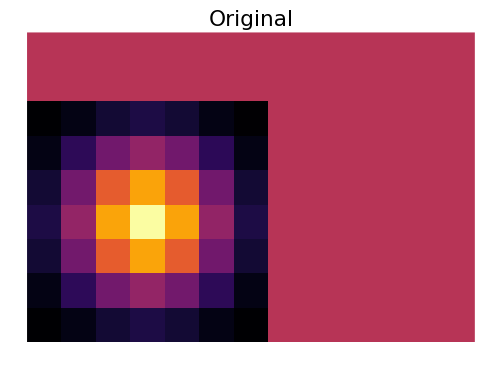

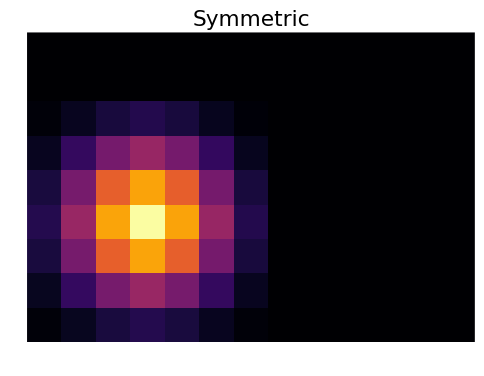

INFO:lsst.meas.deblender:Max difference: 0.5
INFO:lsst.meas.deblender:Min difference: -2.77555756156e-16


In [5]:
testSym(patch, slice(None, width), slice(None, width), cx, cy, shape, zeros=False);
testSym(patch, slice(-width, None), slice(None, width), shape[1]-cx-1, cy, shape, zeros=False);
testSym(patch, slice(-width, None), slice(-width, None), shape[1]-cx-1, shape[0]-cy-1, shape, zeros=False);
testSym(patch, slice(None, width), slice(-width, None), cx, shape[0]-cy-1, shape, zeros=False);

In [6]:
def testMonotonic(shape, px, py):
    # Create a pyramid with shape ``shape``, centered on the image
    x = np.linspace(-1,1, shape[1])
    y = np.linspace(-1,1, shape[0])
    cx = shape[1]//2
    cy = shape[0]//2
    X,Y = np.meshgrid(x,y)
    pyramid = np.zeros(shape)
    pyramid[:cy+1, :cx+1] = (X+Y)[:cy+1, :cx+1]
    pyramid[:cy+1, cx+1:] = (Y-X)[:cy+1, cx+1:]
    pyramid[cy+1:, :cx+1] = (X-Y)[cy+1:, :cx+1]
    pyramid[cy+1:, cx+1:] = (-X-Y)[cy+1:, cx+1:]
    pyramid -= np.min(pyramid)
    plt.imshow(pyramid)
    plt.title("Image")
    plt.show()
    
    # Get a monotonic operator centered on peakX, peakY
    monotonic = proximal_nmf.getRadialMonotonicOp(shape, px, py)
    # Show the gradient
    grad = monotonic.dot(pyramid.flatten())
    plt.imshow(grad.reshape(shape))
    plt.title("Radial Gradient")
    plt.show()
    # Get the non-monotonic pixels
    badGrad = np.zeros(pyramid.size)
    badGrad[grad<0] = 1
    plt.imshow(badGrad.reshape(shape))
    plt.title("Non-Monotonic Pixels")
    plt.show()
    # Test that every pixels is used
    height, width = shape
    logger.info("Pixels not used: {0}".format(np.trace(monotonic.toarray())+height*width-1))
    # Test that each pixel is used as a reference at least once
    indices = np.arange(height*width)
    edges = ((np.mod(indices, width)==0) | 
             (indices<width) | 
             (indices>=width*(height-1)) | 
             (np.mod(indices, width)==width-1))
    references = np.sum(monotonic.toarray(), axis=0)[~edges]
    logger.info("Pixels not used as a reference: {0}".format(np.sum(references<0)))

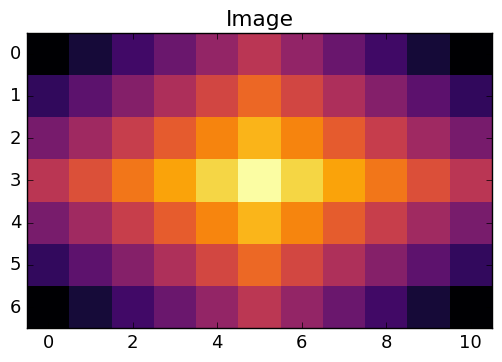

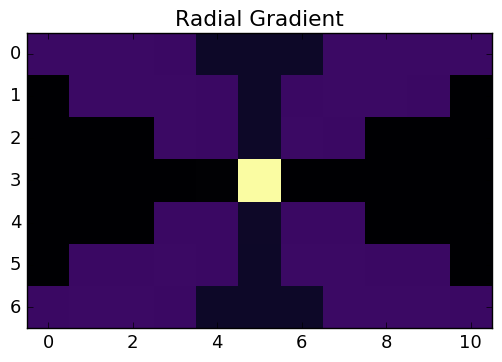

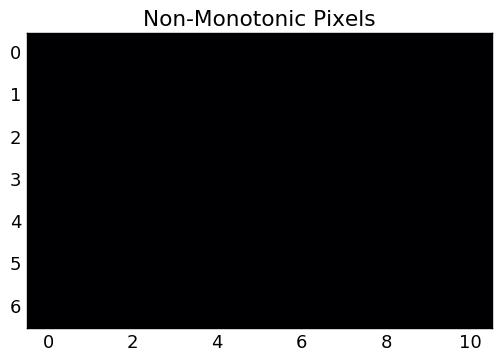

INFO:lsst.meas.deblender:Pixels not used: 1.0
INFO:lsst.meas.deblender:Pixels not used as a reference: 0


In [7]:
#testMonotonic(shape=(7,7), px=3, py=3)
#testMonotonic(shape=(11,7), px=3, py=5)
testMonotonic(shape=(7,11), px=5, py=3)

# Test the monotonicity operator centered at a point other than the peak

This shows errors in the radial gradiant, with multiple non-monotonic pixels

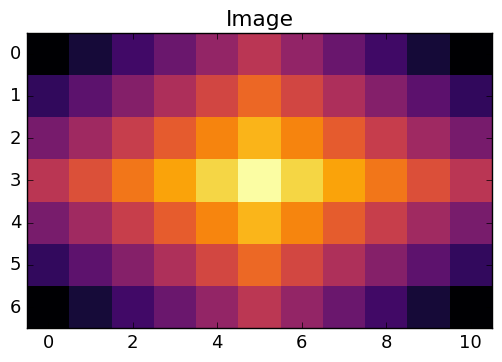

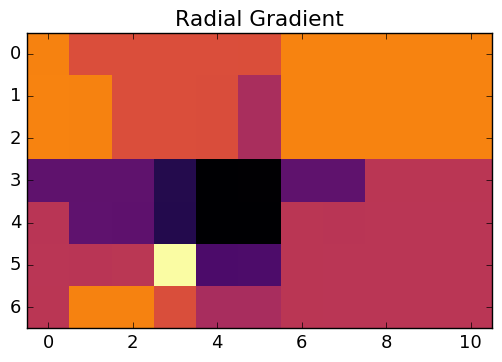

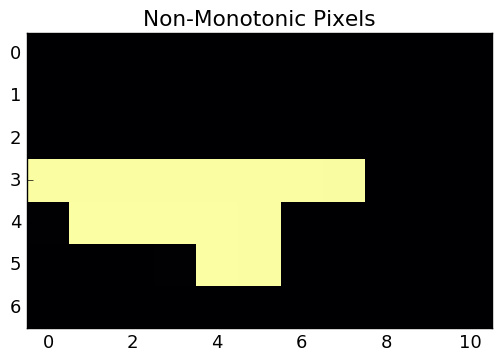

INFO:lsst.meas.deblender:Pixels not used: 1.0
INFO:lsst.meas.deblender:Pixels not used as a reference: 0


In [8]:
testMonotonic(shape=(7,11), px=3, py=5)

In [9]:
def plotSparsePixels(arr, shape, useMask=True, vmin=None, vmax=None):
    height, width = shape
    if vmin is None:
        vmin = np.min(arr)
    if vmax is None:
        vmax = np.max(arr)
    d = np.ma.array(arr, mask=(arr==0))
    plt.imshow(d, vmin=vmin, vmax=vmax)
    plt.show()
    
    fig = plt.figure(figsize=(9,3))
    for h in range(height):
        for w in range(width):
            pixel = h*width + w
            ax = fig.add_subplot(height, width, pixel+1)
            ax.imshow(d[pixel].reshape(shape), vmin=vmin, vmax=vmax)
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

def getOffsets(width):
    offsets = [-width-1, -width, -width+1, -1, 1, width-1, width, width+1]
    slices = [slice(None, s) if s<0 else slice(s, None) for s in offsets]
    slicesInv = [slice(-s, None) if s<0 else slice(None, -s) for s in offsets]
    return offsets, slices, slicesInv

def diagonalizeArray(arr, shape=None, dtype=np.float64):
    """Convert an array to a matrix that compares each pixel to its neighbors
    
    Given an array with length N, create an 8xN array, where each row will be a
    diagonal in a diagonalized array.
    """
    if shape is None:
        height, width = arr.shape
        data = arr.flatten()
    elif len(arr.shape)==1:
        height, width = shape
        data = np.copy(arr)
    else:
        raise ValueError("Expected either a 2D array or a 1D array and a shape")
    size = width * height
    
    # We hard code 8 rows, since each row corresponds to a neighbor
    # of each pixel.
    diagonals = np.zeros((8, size), dtype=dtype)
    mask = np.ones((8, size), dtype=bool)
    offsets, slices, slicesInv = getOffsets(width)
    for n, s in enumerate(slices):
        diagonals[n][slicesInv[n]] = data[s]
        mask[n][slicesInv[n]] = 0
    
    mask[0][np.arange(1,height)*width] = 1
    mask[2][np.arange(height)*width-1] = 1
    mask[3][np.arange(1,height)*width] = 1
    mask[4][np.arange(1,height)*width-1] = 1
    mask[5][np.arange(height)*width] = 1
    mask[7][np.arange(1,height-1)*width-1] = 1
    
    return diagonals, mask

def diagonalsToSparse(diagonals, shape, dtype=np.float64):
    height, width = shape
    offsets, slices, slicesInv = getOffsets(width)
    diags = [diag[slicesInv[n]] for n, diag in enumerate(diagonals)]
    
    #diags[0][np.arange(1,height-1)*width-1] = 0
    #diags[2][np.arange(height)*width] = 0
    #diags[3][np.arange(1,height)*width-1] = 0
    #diags[4][np.arange(1,height)*width-1] = 0
    #diags[5][np.arange(height)*width] = 0
    #diags[7][np.arange(1,height-1)*width-1] = 0
    
    diagonalArr = sparse.diags(diags, offsets, dtype=dtype)
    return diagonalArr

def getMonotonic(shape, px, py, display=True):
    # Calculate the distance between each pixel and the peak
    x = np.arange(shape[1])
    y = np.arange(shape[0])
    X,Y = np.meshgrid(x,y)
    X = X - px
    Y = Y - py
    distance = np.sqrt(X**2+Y**2)
    if display:
        plt.figure(figsize=(3,3))
        plt.imshow(distance+1, vmin=0, vmax=np.max(distance+1))
        plt.show()
    
    # Find neighbors further from the peak
    # (to remove them later)
    distArr, mask = diagonalizeArray(distance, dtype=np.float64)
    relativeDist = (distance.flatten()[:,None]-distArr.T).T
    invalidPix = relativeDist<=0
    
    # Calculate the angle between each pixel and the x axis,
    # relative to the peak position
    inf = X==0
    tX = X.copy()
    tX[inf] = 1
    angles = np.arctan2(-Y,-tX)
    angles[inf&(Y!=0)] = 0.5*np.pi*np.sign(angles[inf&(Y!=0)])
    
    # Calcualte the angle between each pixel and it's neighbors
    xArr, m = diagonalizeArray(X)
    yArr, m = diagonalizeArray(Y)
    dx = (xArr.T-X.flatten()[:, None]).T
    dy = (yArr.T-Y.flatten()[:, None]).T
    # Avoid dividing by zero, so we later reset these pixels
    inf = dx==0
    dx[inf] = 1
    relativeAngles = np.arctan2(dy,dx)
    relativeAngles[inf&(dy!=0)] = 0.5*np.pi*np.sign(relativeAngles[inf&(dy!=0)])
    
    # Find the difference between each pixels angle with the peak
    # and the relative angles to its neighbors, and take the
    # cos to find its neighbors weight
    dAngles = (angles.flatten()[:, None]-relativeAngles.T).T
    cosWeight = np.cos(dAngles)
    cosWeight[invalidPix] = 0
    cosWeight[mask] = 0
    
    # Test, this should work using only the point with the highest weight
    nearest = np.argmax(cosWeight, axis=0)
    nrange = np.arange(nearest.shape[0])
    nidx = nearest+nrange*cosWeight.shape[0]
    tempWeight = np.zeros(cosWeight.size)
    tempWeight[nidx] = cosWeight.T.flatten()[nidx]
    cosWeight = tempWeight.reshape(cosWeight.T.shape).T
    
    # Normalize the cos weights for each pixel
    normalize = np.sum(cosWeight, axis=0)
    normalize[normalize==0] = 1
    cosNorm = (cosWeight.T/normalize[:,None]).T
    cosNorm[mask] = 0
    cosArr = diagonalsToSparse(cosNorm, shape)
    
    """
    # Use only the source with the smallest angle
    nearest = np.ma.argmax(np.ma.array(cosNorm, mask=cosNorm==0), axis=0)
    test = np.arange(nearest.shape[0])
    nn = nearest+test*cosNorm.shape[0]
    monotonic = np.zeros(cosNorm.size)
    monotonic[nn] = cosNorm.T.flatten()[nn]
    
    print(cosNorm.shape)
    nnn = 0
    for n in range(len(nearest)):
        print(n, nearest[n], cosNorm.T[n][nearest[n]], monotonic[nn[nnn]])
        nnn += 1
    
    print(cosArr.shape, nearest.shape, nearest, nn)
    print(monotonic)
    
    monotonic = monotonic.reshape(cosNorm.T.shape).T
    
    cosArr = diagonalsToSparse(monotonic, shape)"""
    
    diagonal = np.ones(size)
    diagonal[px+py*shape[1]] = 0
    monotonic = cosArr-sparse.diags(diagonal)
    
    return monotonic.todia()#, (cosWeight, relativeAngles, angles, dAngles, invalidPix, xArr, X, mask, normalize)

In [10]:
def plotSparsePixels(arr, shape, useMask=True, vmin=None, vmax=None):
    """Plot the monotonicity operator and the neighor values used for each reference pixel
    """
    height, width = shape
    if vmin is None:
        vmin = np.min(arr)
    if vmax is None:
        vmax = np.max(arr)
    d = np.ma.array(arr, mask=(arr==0))
    plt.imshow(d, vmin=vmin, vmax=vmax)
    plt.show()
    
    fig = plt.figure(figsize=(9,3))
    for h in range(height):
        for w in range(width):
            pixel = h*width + w
            ax = fig.add_subplot(height, width, pixel+1)
            ax.imshow(d[pixel].reshape(shape), vmin=vmin, vmax=vmax)
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

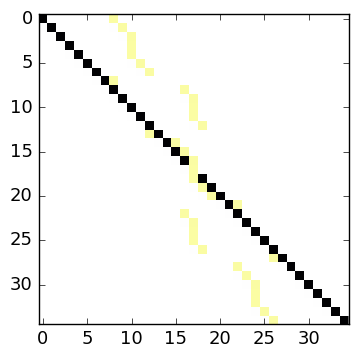

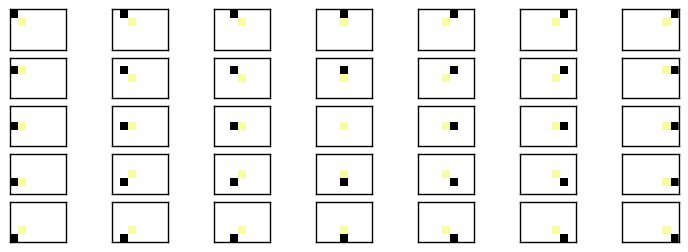

In [11]:
width = 7
height = 5
shape = (height, width)
px = int((width-1)/2)
py = int((height-1)/2)
x = np.arange(shape[1])
y = np.arange(shape[0])
size = shape[0]*shape[1]
X,Y = np.meshgrid(x,y)
X = X - px
Y = Y - py
distance = np.sqrt(X**2+Y**2)
mono = proximal_nmf.getRadialMonotonicOp(shape, px, py)
#mono, debugs = getMonotonic(shape, px, py)
#cosWeight, relativeAngles, angles, dAngles, invalid, xArr, X, mask, normalize = debugs
plotSparsePixels(mono.toarray(), shape, vmin=0)

# Test that an operator can be quickly built for a very large footprint

In [13]:
width = 1001
height = 1001
shape = (height, width)
px = int((width-1)/2)
py = int((height-1)/2)
x = np.arange(shape[1])
y = np.arange(shape[0])
size = shape[0]*shape[1]
X,Y = np.meshgrid(x,y)
X = X - px
Y = Y - py
distance = np.sqrt(X**2+Y**2)
%timeit mono = proximal_nmf.getRadialMonotonicOp(shape, px, py)

1 loop, best of 3: 922 ms per loop
